<h2> Dieses Notebook führt die Volumenschätzung ausschließlich aus Basis der Tiefenwerte, intrinsischen Matrix und referenz Dimensionen aus, welche direkt aus dem IPhone via Apple SDK gewonnen wurden.

# Import der Libraries

In [39]:
from PIL import Image, ImageOps, ImageFilter
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import cv2
import glob
from camera_intrinsic import get_camera_intrinsics
from exif_extract import transform_jpeg_to_depthmap_samsungs20
from exif_extract import transform_jpeg_to_depthmap_iphone
from binary_dm import transform_binary_to_depthmap

# Tiefenkarte lesen und plotten

Einlesen der Binary

In [40]:
binary_url = r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\XCodeDirectExtraction\LidarData\DepthMap5.bin"
depth_map = transform_binary_to_depthmap(binary_url)

In [80]:
print(depth_map.dtype)


float16


Einlesen des RGB image

In [41]:
rgb_url = r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\XCodeDirectExtraction\LidarData\color_image.jpg"
rgb_im = Image.open(rgb_url)

In [52]:
rgb_height, rgb_width =rgb_im.size
rgb_height

1920

Plotten der Tiefenkarte

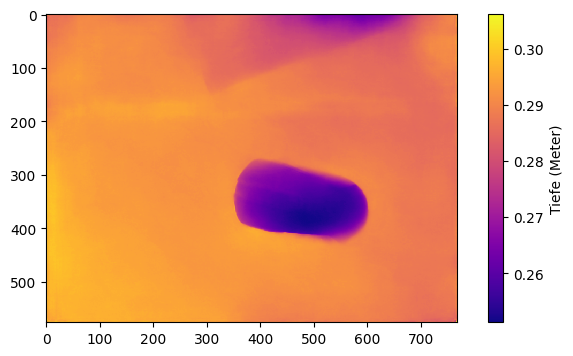

In [53]:
plt.figure(figsize=(8, 4))
plt.imshow(depth_map, cmap="plasma", interpolation="nearest")
plt.colorbar(label="Tiefe (Meter)")
plt.show()


We need to resize the rgb image later to this size to combine depth map and RGB image and create a RGBD image. First we get the size of the depth map and then resize the RGB image to that size.

In [ ]:
def resize(rgb_im, depth_im):
    rgb_width, rgb_height = rgb_im.size
    rgb_width_original, rgb_height_original = rgb_im.size #need that for later use
    dm_width, dm_height = depth_im.size  # width and height of depth map image. 
    
    print(f"dm_height:{dm_height}, dm_width:{dm_width}\n rgb_height:{rgb_height}, rgb_width:{rgb_width}")  # need to scale our RGB image to the size of our depthmap image
    
    size = (dm_width, dm_height)  # define new size
    rgb_im = rgb_im.resize(size)  # fitting the rgb image size to the size of the depth image
    
    rgb_width, rgb_height = rgb_im.size
    print(f"new_rgb_height:{rgb_height}, new_rgb_width:{rgb_width}")
    
    return rgb_im, dm_width, dm_height, rgb_width_original, rgb_height_original

# Exiftool camera calibration

In [54]:
dm_height, dm_width= depth_map.shape
dm_height

576

intrinsische Matrix

In [55]:
intrinsic_matrix = np.array([
    [2943.626708984375, 0, 2006.96923828125],
    [0, 2943.626708984375, 1519.7119140625],
    [0, 0, 1]
])

print(intrinsic_matrix)


[[2.94362671e+03 0.00000000e+00 2.00696924e+03]
 [0.00000000e+00 2.94362671e+03 1.51971191e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


Referenzdimensionen für die Skalierung der intrinsischen Matrix

In [56]:
#OriginalWerte
# ref_height = 4032
# ref_width = 3024

In [58]:
#Diese Werte nutze ich zum testen, da die Tiefekarte gekippt ist, sind auch höhe und breite vertauscht
ref_height = 3024
ref_width = 4032

In [60]:
# sclaingfactor
scale_x = dm_width / ref_width
scale_y = dm_height / ref_height

# scaling
scaled_mtx = intrinsic_matrix.copy()
scaled_mtx[0, 0] *= scale_x  # f_x
scaled_mtx[1, 1] *= scale_y  # f_y
scaled_mtx[0, 2] *= scale_x  # c_x
scaled_mtx[1, 2] *= scale_y  # c_y

print("Angepasste intrinsische Matrix:")
print(scaled_mtx)

Angepasste intrinsische Matrix:
[[560.69080171   0.         382.27985491]
 [  0.         560.69080171 289.46893601]
 [  0.           0.           1.        ]]


because the depthmap is already processes by the IPhone and normalized, I have to scale to numbers back to meters. the maximum depth captured by the LIDAR sensor seems to be 5 meters.
so the maximum value of the unedited array, which is 255, is equal to 5 meters while 0 = 0 meters.

scaled intrinsic

In [66]:
fx = scaled_mtx[0, 0]
fy = scaled_mtx[1, 1]
cx = scaled_mtx[0, 2]
cy = scaled_mtx[1, 2]

print(f"fx: {fx}, fy: {fy}, cx: {cx}, cy: {cy}")


# Intrinsic Matrix als Open3D-Objekt
intrinsic_scaled = o3d.camera.PinholeCameraIntrinsic(width=dm_width, height=dm_height, fx=fx, fy=fy, cx=cx, cy=cy)


fx: 560.6908017113095, fy: 560.6908017113095, cx: 382.2798549107143, cy: 289.46893601190476


# Create point cloud

Open3D Object without metric scaling

In [75]:
depth_data_uint16_Iphone = (depth_map.astype(np.uint16)) #Quelle: https://stackoverflow.com/questions/73067231/how-to-convert-uint8-image-to-uint16-python
depth_uint16_o3d_Iphone = o3d.geometry.Image(depth_data_uint16_Iphone)

# Open3D-Image aus Tiefenkarte erstellen
depth_image = o3d.geometry.Image(depth_uint16_o3d_Iphone)

In [81]:
depth_image = o3d.geometry.Image(depth_map.astype(np.float32))

Pointcloud

In [84]:
pcd = o3d.geometry.PointCloud.create_from_depth_image(
    depth_image,
    intrinsic_scaled,
    depth_scale=1.0,  # 
    depth_trunc=3.0,  # Maximal erlaubte Tiefe reicht für unsere Ansprüche auf 3
    stride=1  # Jeder Pixel wird genutztbei Stride = 1
)


In [85]:
o3d.visualization.draw_geometries([pcd])

In [86]:
num_points = len(np.asarray(pcd.points))
print(f"Anzahl der Punkte in der Punktwolke: {num_points}")

Anzahl der Punkte in der Punktwolke: 442368
